In [2]:
import boule as bl
import ensaio
import numpy as np
import pandas as pd
import pygmt
import verde as vd
import xarray as xr
import harmonica as hm
import scipy as scipy
from numba import njit
import matplotlib.pyplot as plt

# Load Moho & LAB and NearestNDInterpolator Function

In [3]:
# Moho                     
moho_file_path = 'moho_depth.csv'
moho_df = pd.read_csv(moho_file_path)

camlab_file_path = "D:\\Amitava\\Projects\\Perple_X\\V2RhoT_gibbs\\LAB_geoid_data\\CAM2022_lithosphere.xyz"
camlab_df = pd.read_csv(camlab_file_path, delim_whitespace=True, header=None, names=['Latitude', 'Longitude', 'Depth'])

fname = ensaio.fetch_earth_topography(version=1)
topo = xr.load_dataarray(fname)

# Topo
topo_file_path = r"D:\Amitava\Projects\Perple_X\topo\etopo2_downsampled.csv"
topo_df = pd.read_csv(topo_file_path, usecols=['x', 'y', 'z'])
topo_df.rename(columns={'x': 'Longitude', 'y': 'Latitude', 'z': 'Topo'}, inplace=True)      # Rename columns to match interpolation logic
topo_df = topo_df[['Latitude', 'Longitude', 'Topo']]  # Reorder columns

C:\Users\DELL\AppData\Local\Temp\ipykernel_17228\1790229125.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  camlab_df = pd.read_csv(camlab_file_path, delim_whitespace=True, header=None, names=['Latitude', 'Longitude', 'Depth'])


In [4]:
moho_func = scipy.interpolate.NearestNDInterpolator(list(zip(moho_df['Latitude'], moho_df['Longitude'])), moho_df['Moho'])
camlab_func = scipy.interpolate.NearestNDInterpolator(list(zip(camlab_df['Latitude'], camlab_df['Longitude'])), camlab_df['Depth'])
topo_func = scipy.interpolate.NearestNDInterpolator(list(zip(topo_df['Latitude'], topo_df['Longitude'])), topo_df['Topo'])

In [5]:
#region = [west, east, south, north]
#region = [-78, -53, -57, -20] # SA
#region = [112, 155, -45, -10]  # Australia
#region = [68, 98, 6, 38]  # India
region = [-179.9, 179.9, -89.9, 89.9] # World

In [6]:
import random

# Get a random integer between 1 and 10 (inclusive)
random_integer = random.random()
print(random_integer)

0.9629846615718337


# Gravity field for different density layers

In [7]:
'''
%%time
# Use the WGS84 ellipsoid to obtain the mean Earth radius which we'll use to
# reference the tesseroid
ellipsoid = bl.WGS84
mean_radius = ellipsoid.mean_radius

# Define tesseroid with top surface at the mean Earth radius, a thickness of
tesseroids = []
density = []
tess_den = []
dlong=5
dlat=5 # step of 5 degree
longitude_max=175
longitude_min=-175
latitude_max=85
latitude_min=-85
depth_min = 0 ## centre of the earth
depth_max = mean_radius  # ~6371e3
ddepth=100e3

for lat in np.arange(latitude_min, latitude_max,dlat):   
    for lon in np.arange(longitude_min, longitude_max,dlong):
        #depth_max = (camlab_func(lat, lon) *1e3)
        # Assigning density for various layers
        topo = topo_func(lat, lon) *1e3
        moho = moho_func(lat, lon) *1e3
        lab = camlab_func(lat, lon) *1e3

        for depth in np.arange(depth_min, depth_max, ddepth): # centre to top
            r_top = mean_radius - depth
            r_bottom = mean_radius - min(depth + ddepth, depth_max)
            #r_bottom = float(mean_radius - depth)
            #r_top = float(mean_radius - depth + ddepth)

            tesseroids.append([lon, lon + dlong, lat, lat + dlat, r_bottom, r_top])

            radius_mid = 0.5 * (r_top + r_bottom) #mean_radius-depth

            if topo < 0:
                # Oceanic
                if r_bottom >= mean_radius + topo:
                    rho_top, rho_bottom = 1000.0, 1040.0  # Seawater
                elif r_bottom >= mean_radius - moho:
                    rho_top, rho_bottom = 2850.0, 2950.0  # Oceanic crust
                elif r_bottom >= mean_radius - lab:
                    rho_top, rho_bottom = 3250.0, 3350.0  # Lithospheric mantle
                elif r_bottom <= 660e3:
                    rho_top, rho_bottom = 3350.0, 4500.0  # Upper mantle
                elif r_bottom <= 2890e3:
                    rho_top, rho_bottom = 4500.0, 5500.0  # Lower mantle
                elif r_bottom <= 5150e3:
                    rho_top, rho_bottom = 9900.0, 11000.0  # Outer core
                else:
                    rho_top, rho_bottom = 12000.0, 13000.0  # Inner core
            else:
                # Continental
                if r_bottom >= mean_radius - moho:
                    rho_top, rho_bottom = 2670.0, 3000.0  # Continental crust
                elif r_bottom >= mean_radius - lab:
                    rho_top, rho_bottom = 3250.0, 3350.0  # Lithospheric mantle
                elif r_bottom <= 660e3:
                    rho_top, rho_bottom = 3350.0, 4500.0  # Upper mantle
                elif r_bottom <= 2890e3:
                    rho_top, rho_bottom = 4500.0, 5500.0  # Lower mantle
                elif r_bottom <= 5150e3:
                    rho_top, rho_bottom = 9900.0, 11000.0  # Outer core
                else:
                    rho_top, rho_bottom = 12000.0, 13000.0  # Inner core

            # Linear profile
            slope = (rho_top - rho_bottom) / (r_top - r_bottom)
            density_mid = slope * (radius_mid - r_bottom) + rho_bottom
            density.append(density_mid)
            tess_den.append([lon, lon + dlong, lat, lat + dlat, r_bottom, r_top, density_mid])

coordinates = vd.grid_coordinates(region=region,shape=(80, 80),extra_coords=100e3 + ellipsoid.mean_radius,)

# Compute the radial component of the acceleration
gravity = hm.tesseroid_gravity(coordinates, tesseroids, density, field="g_z")
print(gravity)
grid = vd.make_xarray_grid(coordinates, gravity, data_names="gravity", extra_coords_names="extra")

# Plot the gravitational field
fig = pygmt.Figure()

title = "Downward component of gravitational acceleration"

with pygmt.config(FONT_TITLE="16p"):
    fig.grdimage(region=region,projection="W25c",grid=grid.gravity,frame=["a", f"+t{title}"],cmap="viridis",)
    
vmin = float(grid.gravity.min())
vmax = float(grid.gravity.max())

fig.colorbar(cmap=True,frame=[f"x+lGravity [mGal]",f"a{vmin:.1f},{vmin:.1f},{vmax:.1f}"])
fig.coast(shorelines="1p,black")

fig.show()
'''

'\n%%time\n# Use the WGS84 ellipsoid to obtain the mean Earth radius which we\'ll use to\n# reference the tesseroid\nellipsoid = bl.WGS84\nmean_radius = ellipsoid.mean_radius\n\n# Define tesseroid with top surface at the mean Earth radius, a thickness of\ntesseroids = []\ndensity = []\ntess_den = []\ndlong=5\ndlat=5 # step of 5 degree\nlongitude_max=175\nlongitude_min=-175\nlatitude_max=85\nlatitude_min=-85\ndepth_min = 0 ## centre of the earth\ndepth_max = mean_radius  # ~6371e3\nddepth=100e3\n\nfor lat in np.arange(latitude_min, latitude_max,dlat):   \n    for lon in np.arange(longitude_min, longitude_max,dlong):\n        #depth_max = (camlab_func(lat, lon) *1e3)\n        # Assigning density for various layers\n        topo = topo_func(lat, lon) *1e3\n        moho = moho_func(lat, lon) *1e3\n        lab = camlab_func(lat, lon) *1e3\n\n        for depth in np.arange(depth_min, depth_max, ddepth): # centre to top\n            r_top = mean_radius - depth\n            r_bottom = mean_rad

[[527482.09582835 527476.98784518 527472.69418409 ... 527494.95521697
  527488.27541977 527482.33854327]
 [528058.37937107 527935.91734828 527851.44271593 ... 528423.30077735
  528226.161337   528064.62426602]
 [536128.15378026 536204.16213171 536691.93358574 ... 537772.07887701
  536751.19386782 536139.92307952]
 ...
 [597366.37465547 596892.64147356 596658.01080054 ... 599216.17227143
  598195.03804762 597394.42528677]
 [597276.20641854 597041.39635646 596871.3217703  ... 597947.15752128
  597587.91621741 597287.97336473]
 [601517.28894172 601508.94941223 601502.43639547 ... 601539.76124844
  601527.87618638 601517.69601954]]


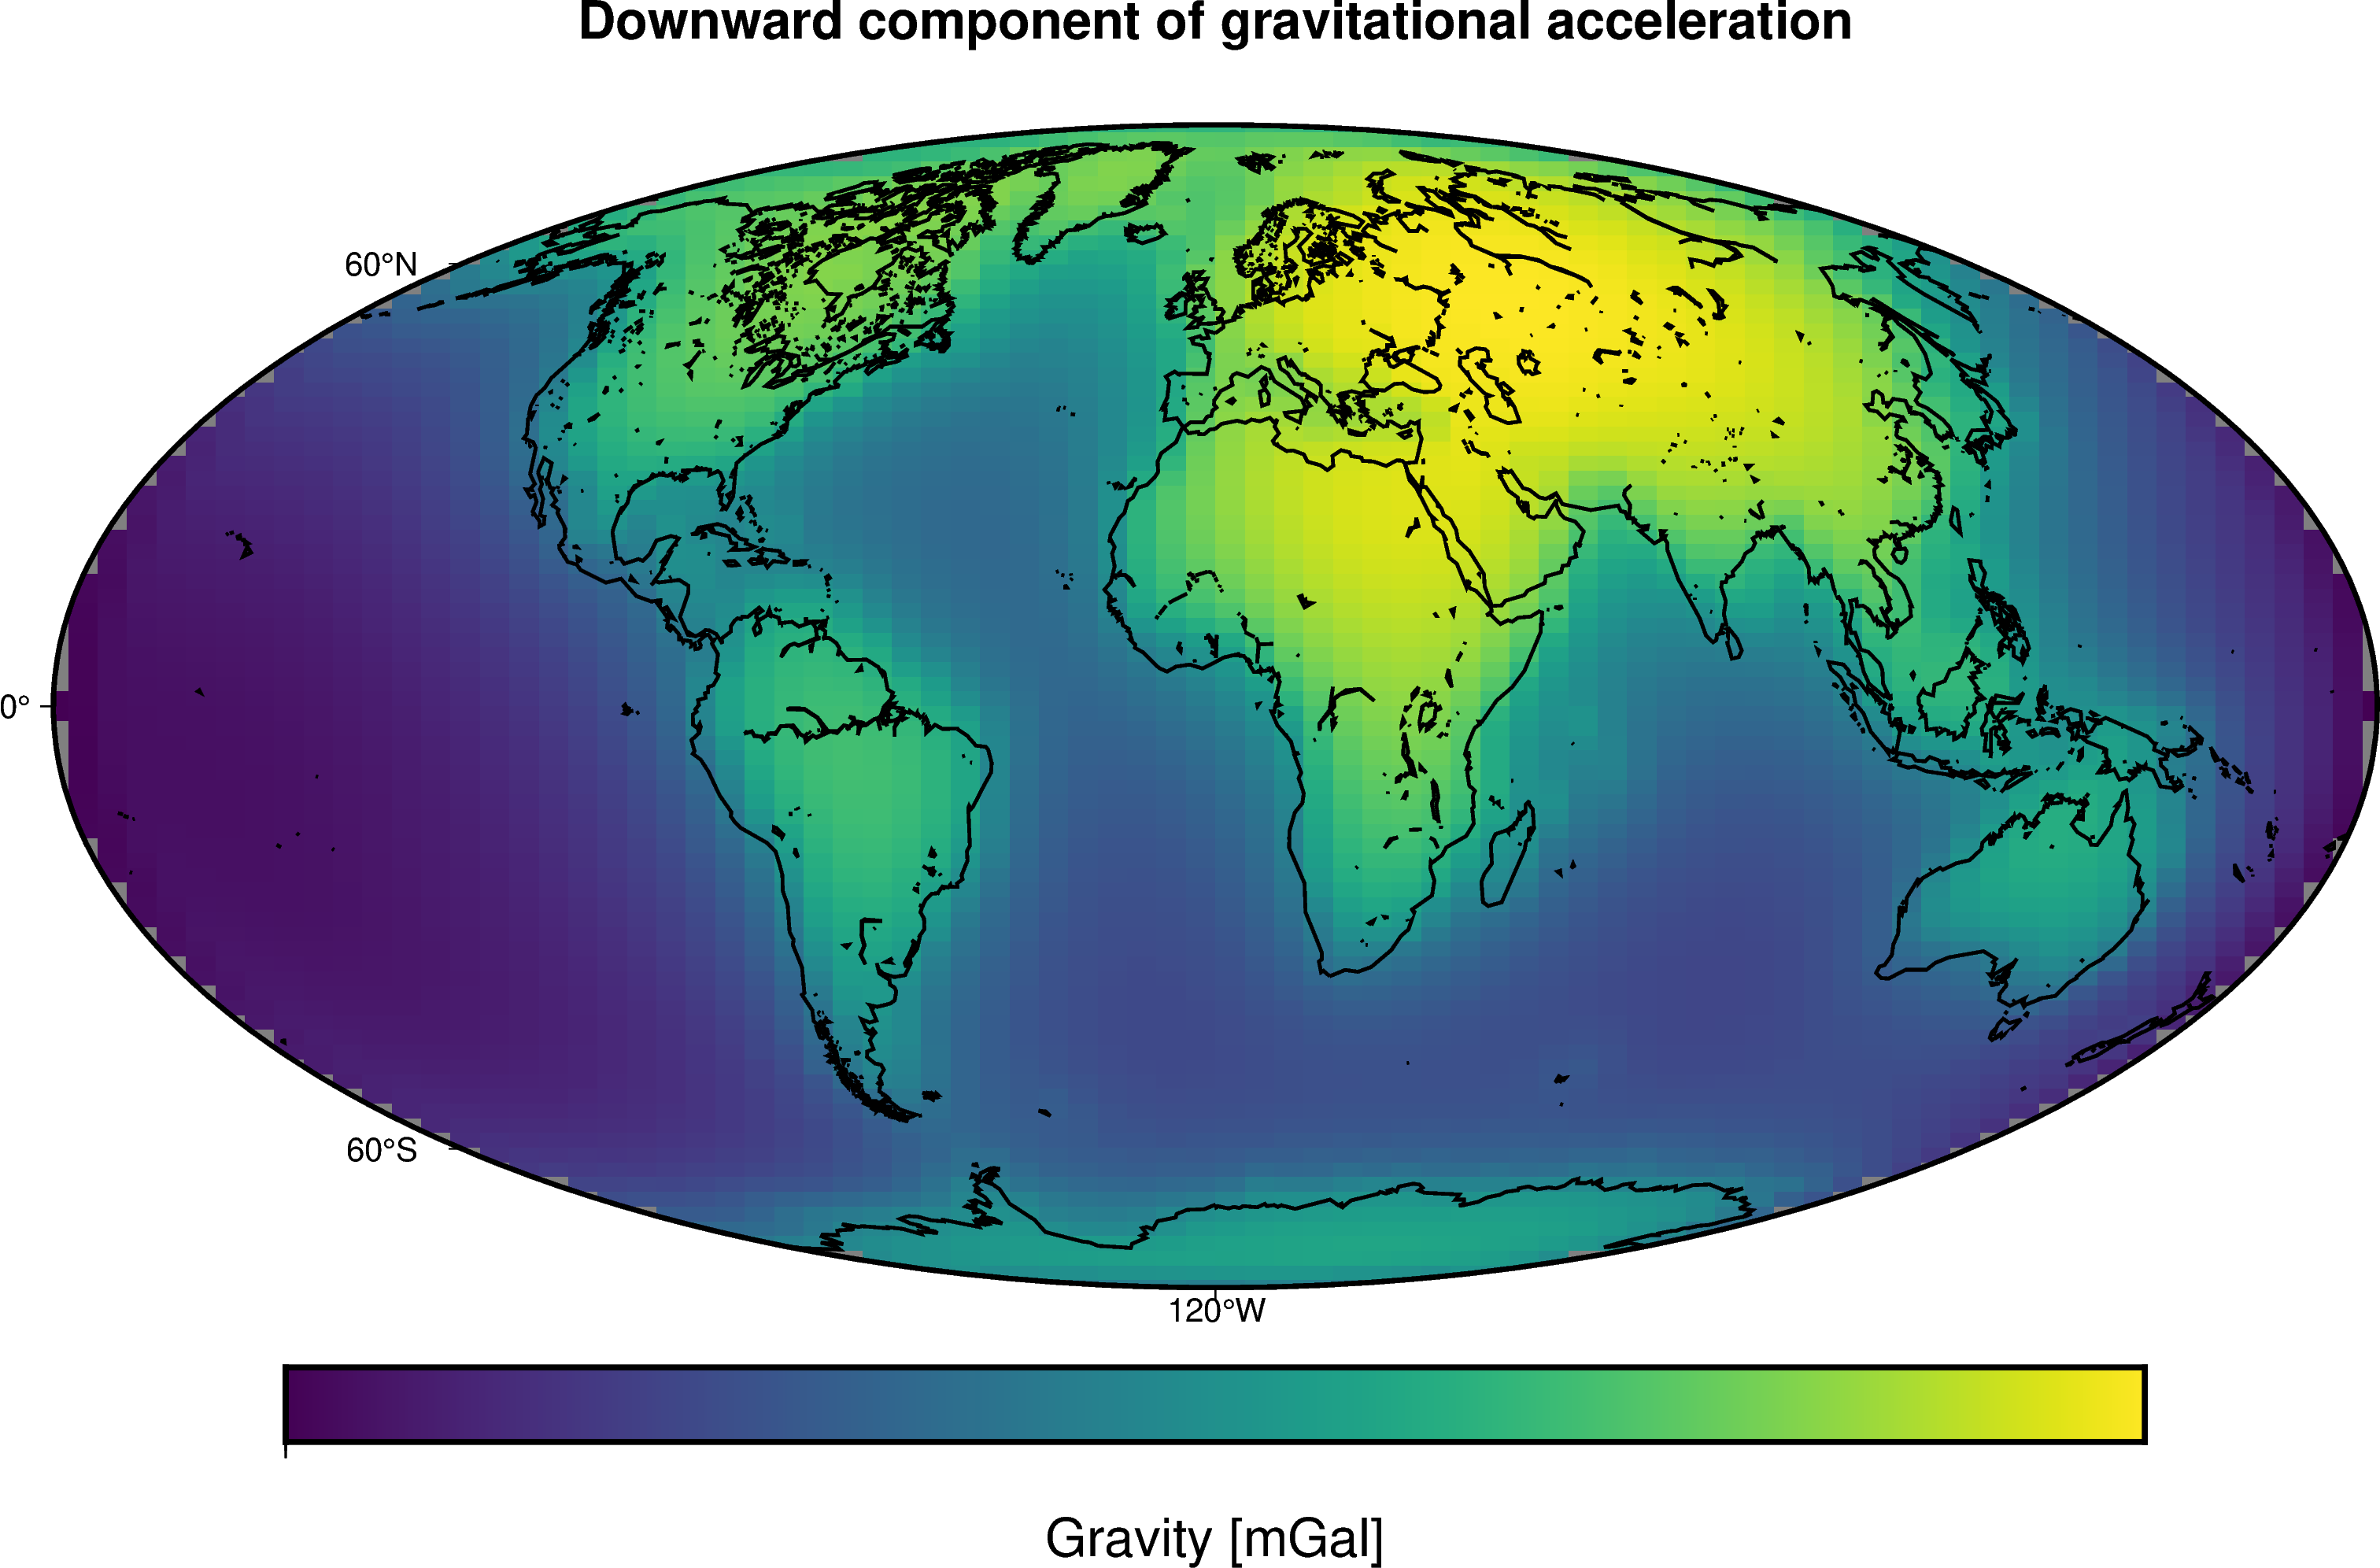

CPU times: total: 7min 27s
Wall time: 45.8 s


In [76]:
%%time
# Use the WGS84 ellipsoid to obtain the mean Earth radius
ellipsoid = bl.WGS84
mean_radius = ellipsoid.mean_radius

tesseroids = []
density = []
tess_den = []
dlong = 5
dlat = 5
longitude_max = 175
longitude_min = -175
latitude_max = 85
latitude_min = -85
depth_min = 0  # centre of the Earth
#depth_max = mean_radius
ddepth = 100e3

for lat in np.arange(latitude_min, latitude_max, dlat):   
    for lon in np.arange(longitude_min, longitude_max, dlong):
        topo = topo_func(lat, lon) * 1e3
        moho = moho_func(lat, lon) * 1e3
        lab = camlab_func(lat, lon) * 1e3


        r_surface = ellipsoid.geocentric_radius(latitude=lat) # in m, for radius corerction 
        depth_max = r_surface
        # Define layer boundaries in radius from Earth's center
        layer_bounds = [r_surface - moho, r_surface - lab, r_surface - 660e3, r_surface - 2890e3, r_surface - 5150e3]
        
        if topo < 0:
            layer_bounds.append(r_surface + topo)
        
        layer_bounds.sort() # sort in ascending order that is (r_surface - 5150e3) to (r_surface - moho) or (r_surface + topo) whichever is true

        for depth in np.arange(depth_min, depth_max, ddepth):
            r_top_raw = r_surface - depth
            r_bottom_raw = r_surface - min(depth + ddepth, depth_max) # min() is used in case depth + ddepth > depth_max which is beyonond the reference

            # Check if tesseroid spans across any layer boundary
            split_layers = [b for b in layer_bounds if r_bottom_raw < b < r_top_raw] ## b represent layer_bounds, so when b is r_bottom_raw < b < r_top_raw is false, then split_layers = []
            split_points = [r_bottom_raw] + split_layers + [r_top_raw] ## if split_points = [r_bottom_raw] + [] + [r_top_global], then  split_points = [r_bottom_raw, r_top_global]

            for i in range(len(split_points) - 1):
                r_bottom = split_points[i]
                r_top = split_points[i + 1]
                tesseroids.append([lon, lon + dlong, lat, lat + dlat, r_bottom, r_top])

                radius_mid = 0.5 * (r_top + r_bottom)
                
                if topo < 0:
                    # Oceanic
                    if r_bottom >= r_surface + topo:
                        rho_top, rho_bottom = 1000.0, 1040.0  # Seawater
                    elif r_bottom >= r_surface - moho:
                        rho_top, rho_bottom = 2850.0, 2950.0  # Oceanic crust
                    elif r_bottom >= r_surface - lab:
                        rho_top, rho_bottom = 3250.0, 3350.0  # Lithospheric mantle
                    elif r_bottom >= r_surface - 660e3:
                        rho_top, rho_bottom = 3350.0, 4500.0  # Upper mantle, MTZ
                    elif r_bottom >= r_surface - 2890e3:
                        rho_top, rho_bottom = 4500.0, 5500.0  # Lower mantle
                    elif r_bottom >= r_surface - 5150e3:
                        rho_top, rho_bottom = 9900.0, 11000.0  # Outer core
                    else:
                        rho_top, rho_bottom = 12000.0, 13000.0  # Inner core
                else:
                    # Continental
                    if r_bottom >= r_surface - moho:
                        rho_top, rho_bottom = 2670.0, 3000.0  # Continental crust
                    elif r_bottom >= r_surface - lab:
                        rho_top, rho_bottom = 3250.0, 3350.0  # Lithospheric mantle
                    elif r_bottom >= r_surface - 660e3:
                        rho_top, rho_bottom = 3350.0, 4500.0  # Upper mantle
                    elif r_bottom >= r_surface - 2890e3:
                        rho_top, rho_bottom = 4500.0, 5500.0  # Lower mantle
                    elif r_bottom >= r_surface - 5150e3:
                        rho_top, rho_bottom = 9900.0, 11000.0  # Outer core
                    else:
                        rho_top, rho_bottom = 12000.0, 13000.0  # Inner core

                slope = (rho_top - rho_bottom) / (r_top - r_bottom)
                density_mid = slope * (radius_mid - r_bottom) + rho_bottom
                density.append(density_mid)
                tess_den.append([lon, lon + dlong, lat, lat + dlat, r_bottom, r_top, density_mid])

   
# g'=g−ω2Rcos2λ
# where:
# g' is the effective acceleration due to gravity,
# g is the acceleration due to gravity without rotation,
# Req is the radius of the Earth at equator,
# ω is the angular velocity of the Earth, and
# λ is the latitude.
# gpoles = g−ω2Rcos290 ∘→ gpole=g  ,example
# gequator = g−ω2cos20 ∘= g−ω2R ,example
def gravity_rot(latitudes_deg):
    omega = 7.2921150e-5  # rad/s
    R_eq = ellipsoid.geocentric_radius(latitude=0)  # 6378137.0 m, WGS84 equatorial radius in meters
    phi_rad = np.radians(latitudes_deg)
    g_c = omega**2 * R_eq * np.cos(phi_rad)**2  # centrifugal accel in m/s²
    return g_c * 1e5  # convert to mGal

coordinates = vd.grid_coordinates(region=region,shape=(80, 80),extra_coords=10e3 + ellipsoid.mean_radius,) # calculated uniformly at 10 km above the WGS84 ellipsoid.

# Compute the radial component of the acceleration
#gravity = hm.tesseroid_gravity(coordinates, tesseroids, density, field="g_z")
gravity_cal = hm.tesseroid_gravity(coordinates, tesseroids, density, field="g_z")

latitudes_deg = coordinates[1] # Extract latitudes from coordinates
gravity = gravity_cal - gravity_rot(latitudes_deg) # effective gravity

print(gravity)
grid = vd.make_xarray_grid(coordinates, gravity, data_names="gravity", extra_coords_names="extra")

# Plot the gravitational field
fig = pygmt.Figure()

title = "Downward component of gravitational acceleration"

with pygmt.config(FONT_TITLE="16p"):
    fig.grdimage(region=region,projection="W25c",grid=grid.gravity,frame=["a", f"+t{title}"],cmap="viridis",)
    
vmin = float(grid.gravity.min())
vmax = float(grid.gravity.max())

fig.colorbar(cmap=True,frame=[f"x+lGravity [mGal]",f"a{vmin:.1f},{vmin:.1f},{vmax:.1f}"])
fig.coast(shorelines="1p,black")

fig.show()

In [77]:
np.shape(np.arange(latitude_min, latitude_max,dlat)),np.shape(np.arange(longitude_min, longitude_max,dlong)),np.shape(np.arange(depth_max,depth_min,-ddepth))

((34,), (70,), (64,))

In [78]:
def count_tesseroids_at_point(target_lat, target_lon, tesseroids):
    """
    Count how many tesseroids lie under a specific latitude and longitude
    using nearest-neighbor interpolation over the lat-lon grid.
    """
    grid_coords = []
    counts = {}

    for tess in tesseroids:
        lon_min, lon_max, lat_min, lat_max, *_ = tess
        key = (lat_min, lon_min)
        if key in counts:
            counts[key] += 1
        else:
            counts[key] = 1
        grid_coords.append(key)

    unique_coords = list(counts.keys())
    values = [counts[coord] for coord in unique_coords]

    interpolator = scipy.interpolate.NearestNDInterpolator(unique_coords, values)
    return int(interpolator(target_lat, target_lon))


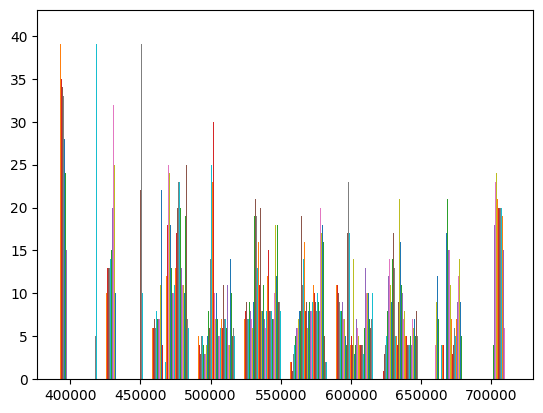

In [79]:
plt.hist(gravity);

In [80]:
lat = 7
lon = -53
print(count_tesseroids_at_point(lat, lon, tesseroids))


69


In [81]:
print("Min gravity:", gravity.min())
print("Max gravity:", gravity.max())

Min gravity: 389330.3972021088
Max gravity: 717283.0678609038


In [82]:
gravity_=gravity.copy()

(array([2.52990012e-06, 2.34885265e-06, 4.85969514e-06, 3.18738828e-06,
        3.99257307e-06, 3.46372389e-06, 3.03492726e-06, 2.79670691e-06,
        2.08681027e-06, 2.19162722e-06]),
 array([389330.39720211, 422125.66426799, 454920.93133387, 487716.19839975,
        520511.46546563, 553306.73253151, 586101.99959739, 618897.26666327,
        651692.53372914, 684487.80079502, 717283.0678609 ]),
 <BarContainer object of 10 artists>)

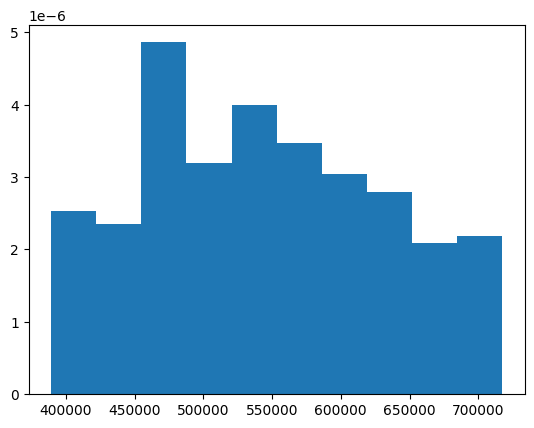

In [83]:
plt.hist(gravity_.flatten(),density=True)

In [84]:
tesseroids = np.array(tesseroids)
density = np.array(density) 
tess_den = np.array(tess_den) 

In [85]:
np.shape(tesseroids)

(165766, 6)

In [86]:
np.shape(tess_den)

(165766, 7)

In [87]:
tess_den

array([[-1.75000000e+02, -1.70000000e+02, -8.50000000e+01, ...,
         6.25691611e+06,  6.31291611e+06,  3.30000000e+03],
       [-1.75000000e+02, -1.70000000e+02, -8.50000000e+01, ...,
         6.31291611e+06,  6.35691611e+06,  2.83500000e+03],
       [-1.75000000e+02, -1.70000000e+02, -8.50000000e+01, ...,
         6.15691611e+06,  6.24791611e+06,  3.92500000e+03],
       ...,
       [ 1.70000000e+02,  1.75000000e+02,  8.00000000e+01, ...,
         1.57402414e+05,  2.57402414e+05,  1.25000000e+04],
       [ 1.70000000e+02,  1.75000000e+02,  8.00000000e+01, ...,
         5.74024138e+04,  1.57402414e+05,  1.25000000e+04],
       [ 1.70000000e+02,  1.75000000e+02,  8.00000000e+01, ...,
         0.00000000e+00,  5.74024138e+04,  1.25000000e+04]])

In [88]:
np.shape(tess_den)

(165766, 7)

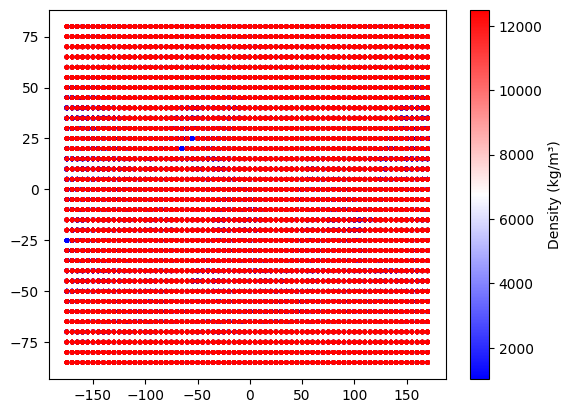

In [89]:
plt.scatter(tess_den[:, 0], tess_den[:, 2], c=tess_den[:, 6], cmap='bwr', s=5)
plt.colorbar(label="Density (kg/m³)")

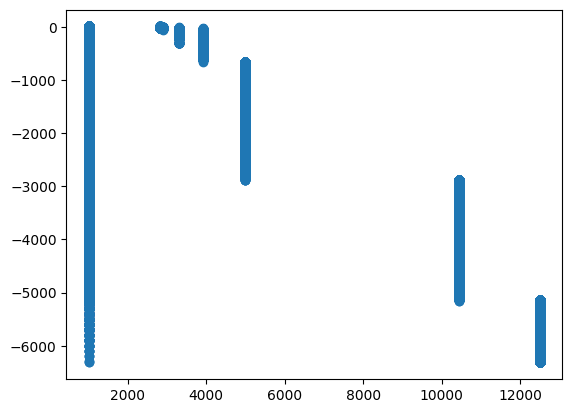

In [90]:
plt.plot(tess_den[:,6],tess_den[:,5]*1e-3-mean_radius*1e-3,'o')


6310994.401827576 6370994.401827576 -60000.0


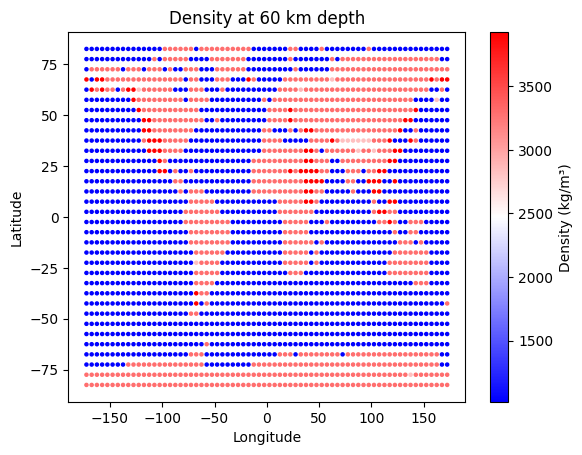

In [91]:
depth_target = 60e3  # 40 km depth
print(radius_target,mean_radius,radius_target-mean_radius)
radius_target = mean_radius - depth_target
mask = (tess_den[:, 4] <= radius_target) & (tess_den[:, 5] >= radius_target)
#mask = (tess_den[:, 4]  radius_target) #& (tess_den[:, 5] >= radius_target)

subset = tess_den[mask]
lon_center = 0.5 * (subset[:, 0] + subset[:, 1])
lat_center = 0.5 * (subset[:, 2] + subset[:, 3])
density = subset[:, 6]
plt.scatter(lon_center, lat_center, c=density, cmap='bwr', s=5) #,vmin=1e3,vmax=3.5e3)
plt.title(f"Density at {depth_target/1e3:.0f} km depth")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Density (kg/m³)")
plt.show()

6310994.401827576 6370994.401827576 -60000.0


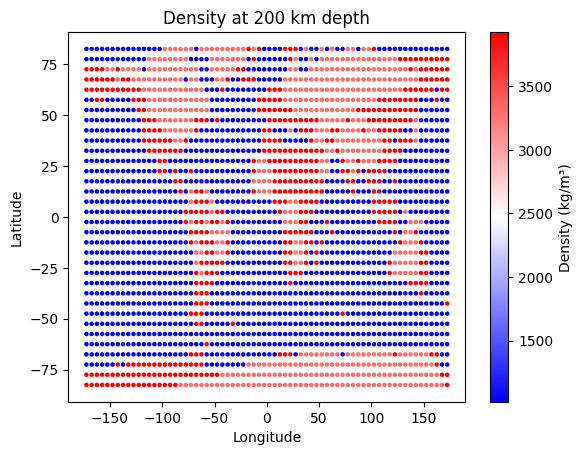

In [92]:
depth_target = 200e3  # 40 km depth
print(radius_target,mean_radius,radius_target-mean_radius)
radius_target = mean_radius - depth_target
mask = (tess_den[:, 4] <= radius_target) & (tess_den[:, 5] >= radius_target)
#mask = (tess_den[:, 4]  radius_target) #& (tess_den[:, 5] >= radius_target)

subset = tess_den[mask]
lon_center = 0.5 * (subset[:, 0] + subset[:, 1])
lat_center = 0.5 * (subset[:, 2] + subset[:, 3])
density = subset[:, 6]
plt.scatter(lon_center, lat_center, c=density, cmap='bwr', s=5) #,vmin=1e3,vmax=3.5e3)
plt.title(f"Density at {depth_target/1e3:.0f} km depth")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Density (kg/m³)")
plt.show()

In [58]:
mask

array([False, False, False, ..., False, False, False])

In [34]:
# tess_den.([lon, lon + dlong, lat, lat + dlat, r_bottom, r_top, density_mid])
all_depths = mean_radius - tess_den[:, 4:6]
print(f"Depth range: {np.min(all_depths):.1f} m to {np.max(all_depths):.1f} m")

Depth range: -7142.6 m to 6370994.4 m


In [35]:
print("First few r_bottom values:", tess_den[:5, 4])
print("Should be ~6,000,000 (not hundreds of thousands)")

First few r_bottom values: [6256916.11430565 6312916.11430565 6156916.11430565 6247916.11430565
 6056916.11430565]
Should be ~6,000,000 (not hundreds of thousands)


In [36]:
grid

<xarray.Dataset> Size: 104kB
Dimensions:   (northing: 80, easting: 80)
Coordinates:
  * easting   (easting) float64 640B -179.9 -175.3 -170.8 ... 170.8 175.3 179.9
  * northing  (northing) float64 640B -89.9 -87.62 -85.35 ... 85.35 87.62 89.9
    extra     (northing, easting) float64 51kB 6.381e+06 6.381e+06 ... 6.381e+06
Data variables:
    gravity   (northing, easting) float64 51kB 8.421e+05 8.421e+05 ... 9.83e+05

In [37]:
# Rename dimensions and coordinates
grid_rename = grid.rename({
    "northing": "latitude",
    "easting": "longitude"
})

# Extract and rename gravity
observed_gravity = grid_rename["gravity"].rename("observed_gravity")

# Include the height/radius as a coordinate
# height = grid_rename["extra"]  # Original radius from center of Earth
lat = observed_gravity.latitude
lon = observed_gravity.longitude

# Create a 2D constant height array of 1000 m
height_2d = xr.DataArray(
    data=np.full((lat.size, lon.size), 10000.0), ## height from the reference
    coords={"latitude": lat, "longitude": lon},
    dims=("latitude", "longitude"),
    name="height"
)

# Assign 2D height as a coordinate
observed_gravity = observed_gravity.assign_coords(height=height_2d)

# Sort for CF compliance
observed_gravity = observed_gravity.sortby(["latitude", "longitude"])

# Set attributes on the data variable
observed_gravity.attrs.update({
    "units": "mGal",
    "long_name": "gravity acceleration",
    "description": "observed gravitational acceleration at Earth's surface",
    "crs": "WGS84",
    "Conventions": "CF-1.8",
    "title": "Observed gravity field",
})

# Optional: add attributes to the height coordinate
observed_gravity.coords["height"].attrs.update({
    "units": "m",
    "long_name": "height above reference ellipsoid",
    "standard_name": "height",
    "positive": "up"
})


In [38]:
observed_gravity

<xarray.DataArray 'observed_gravity' (latitude: 80, longitude: 80)> Size: 51kB
array([[842108.30465161, 842101.4023976 , 842095.98795226, ...,
        842126.8803905 , 842117.06521526, 842108.64146168],
       [845645.30560301, 845579.28625933, 845592.82759802, ...,
        846034.60817998, 845801.64877893, 845650.07686049],
       [866357.30505137, 867442.8733866 , 869216.81172676, ...,
        867136.84265417, 866336.52240765, 866333.12418406],
       ...,
       [968455.03704202, 966991.43723115, 965981.24917366, ...,
        972916.57847296, 970525.42293852, 968531.1777476 ],
       [971066.9098204 , 970451.36501785, 970003.24274192, ...,
        972816.96196333, 971881.01896149, 971097.69531847],
       [982976.63426193, 982955.25163089, 982938.65255348, ...,
        983034.58962836, 983003.90069594, 982977.68064308]])
Coordinates:
  * longitude  (longitude) float64 640B -179.9 -175.3 -170.8 ... 175.3 179.9
  * latitude   (latitude) float64 640B -89.9 -87.62 -85.35 ... 85.35 87.62 89.9
    extra      (latitude, longitude) float64 51kB 6.381e+06 ... 6.381e+06
    height     (latitude, longitude) float64 51kB 1e+04 1e+04 ... 1e+04 1e+04
Attributes:
    units:        mGal
    long_name:    gravity acceleration
    description:  observed gravitational acceleration at Earth's surface
    crs:          WGS84
    Conventions:  CF-1.8
    title:        Observed gravity field

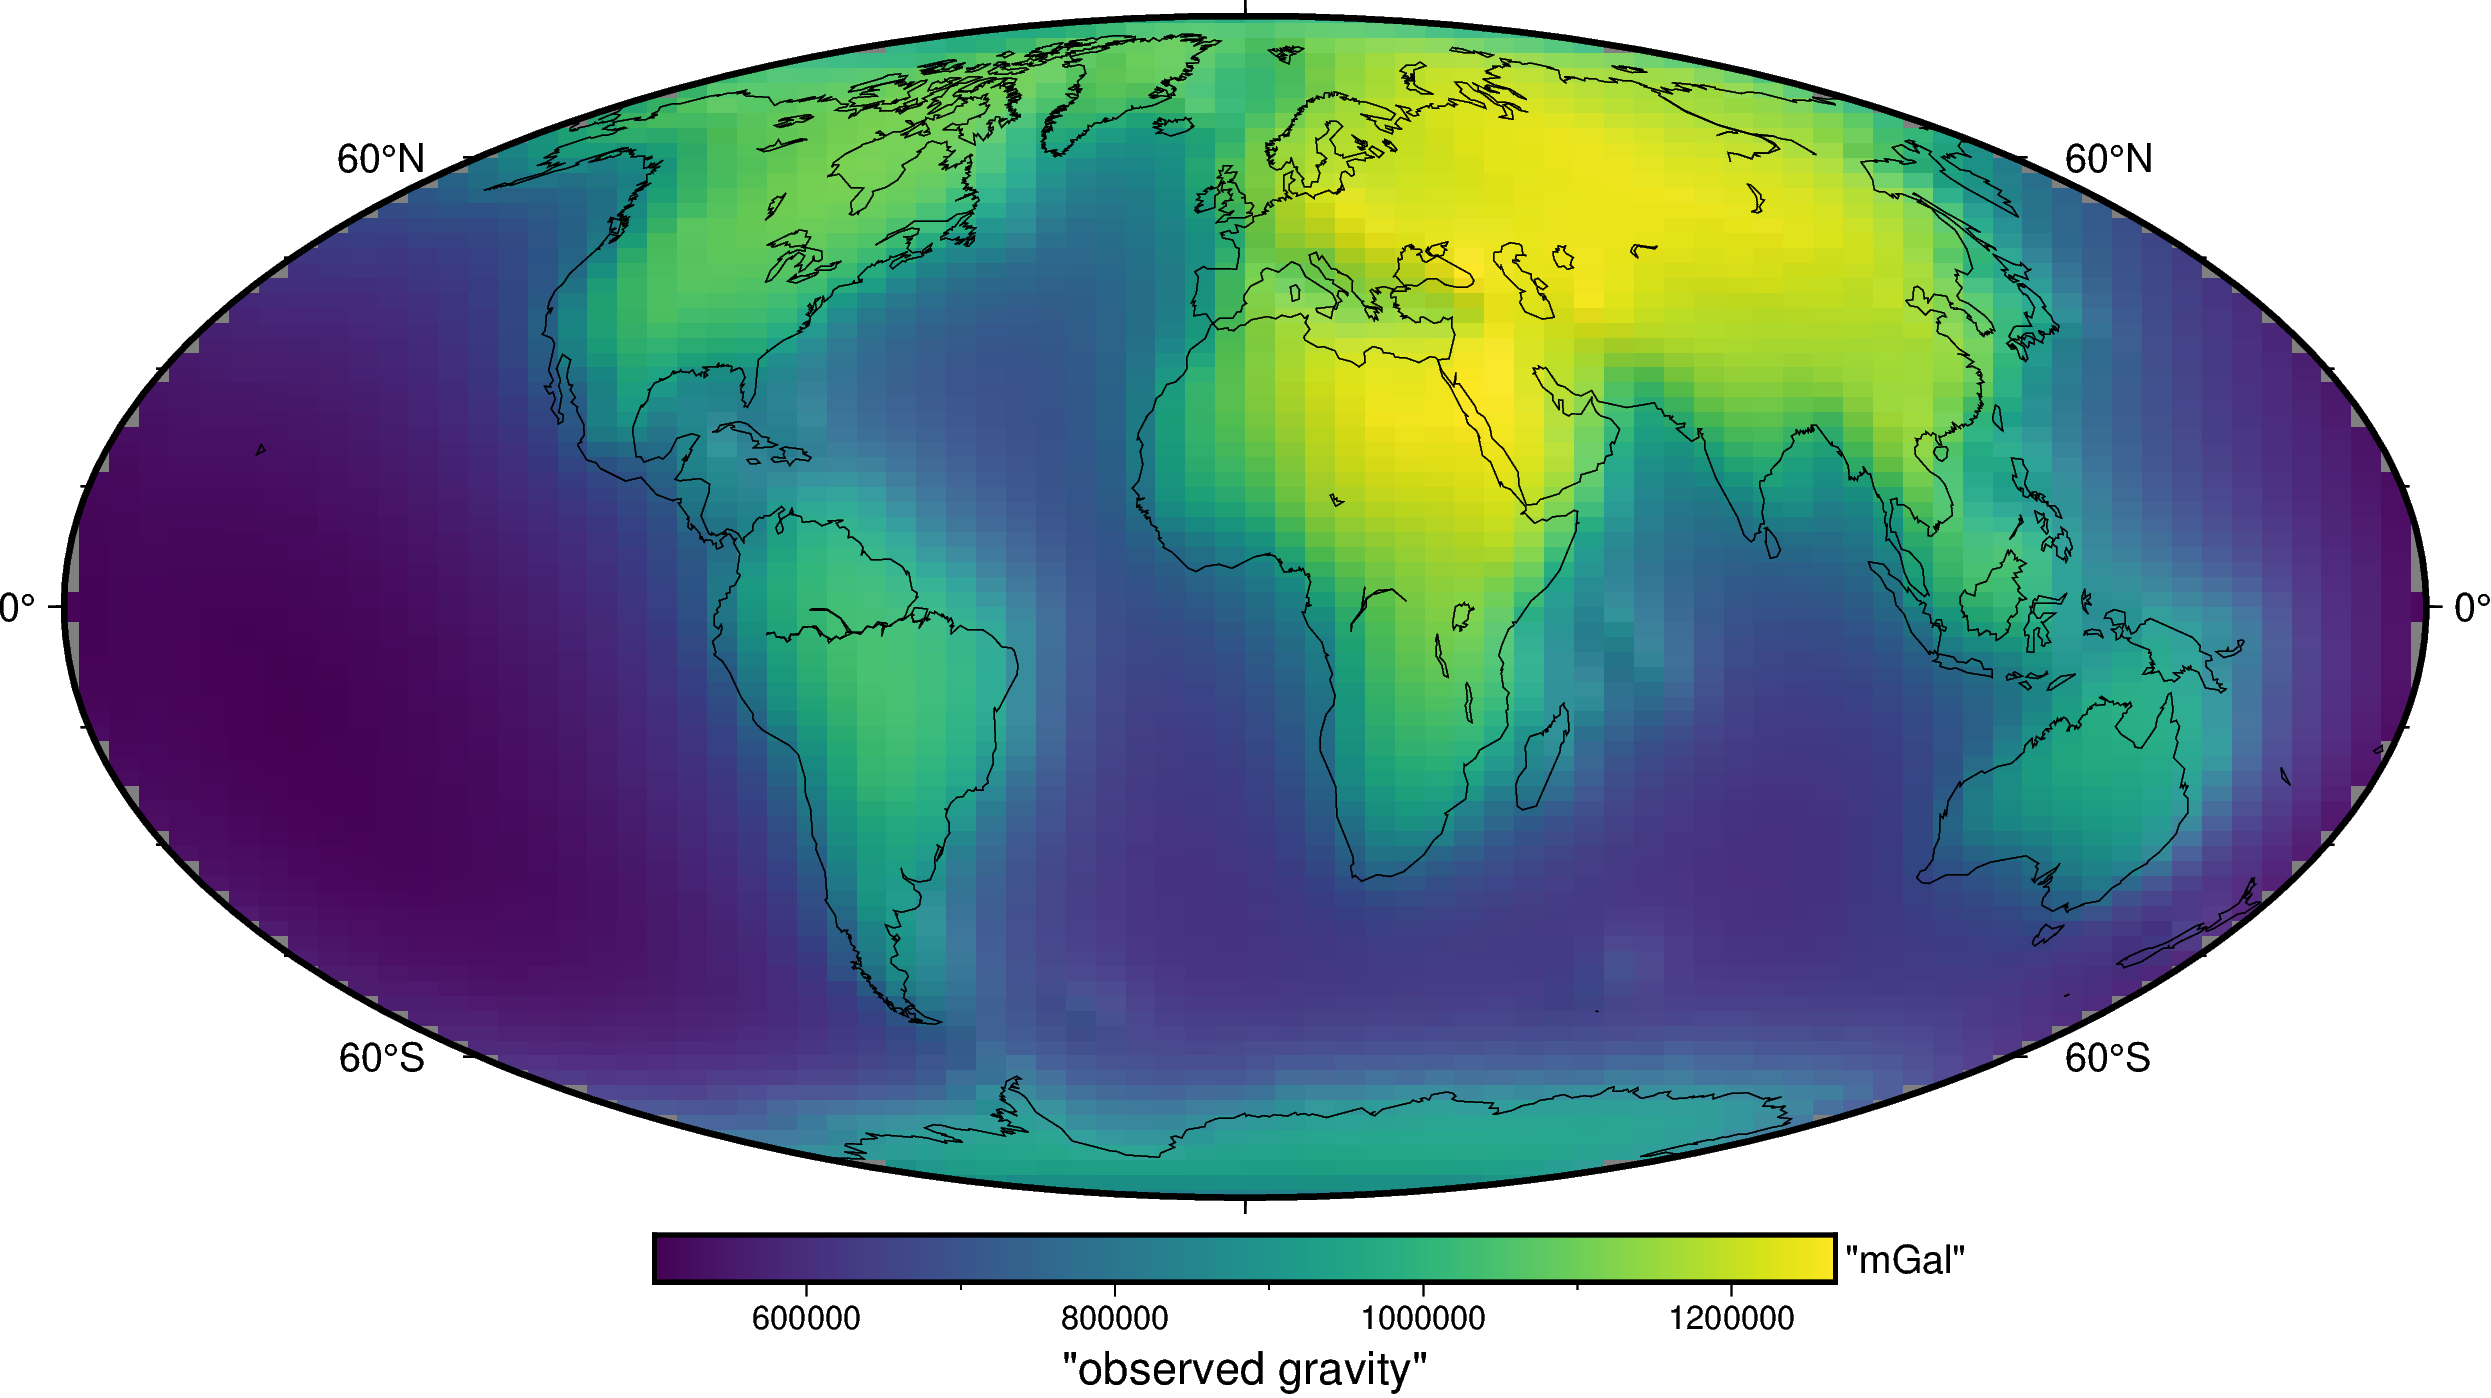

In [25]:
fig = pygmt.Figure()
fig.grdimage(
    observed_gravity,
    projection="W20c",
    cmap="viridis",
    shading="+a45+nt0.2",
)
fig.basemap(frame=["af", "WEsn"])
fig.colorbar(
    position="JCB+w10c",
    frame=["af", 'y+l"mGal"', 'x+l"observed gravity"'],
)
fig.coast(shorelines=True, resolution="c", area_thresh=1e4)
fig.show()

In [26]:
normal_gravity = ellipsoid.normal_gravity(observed_gravity.latitude, observed_gravity.height)

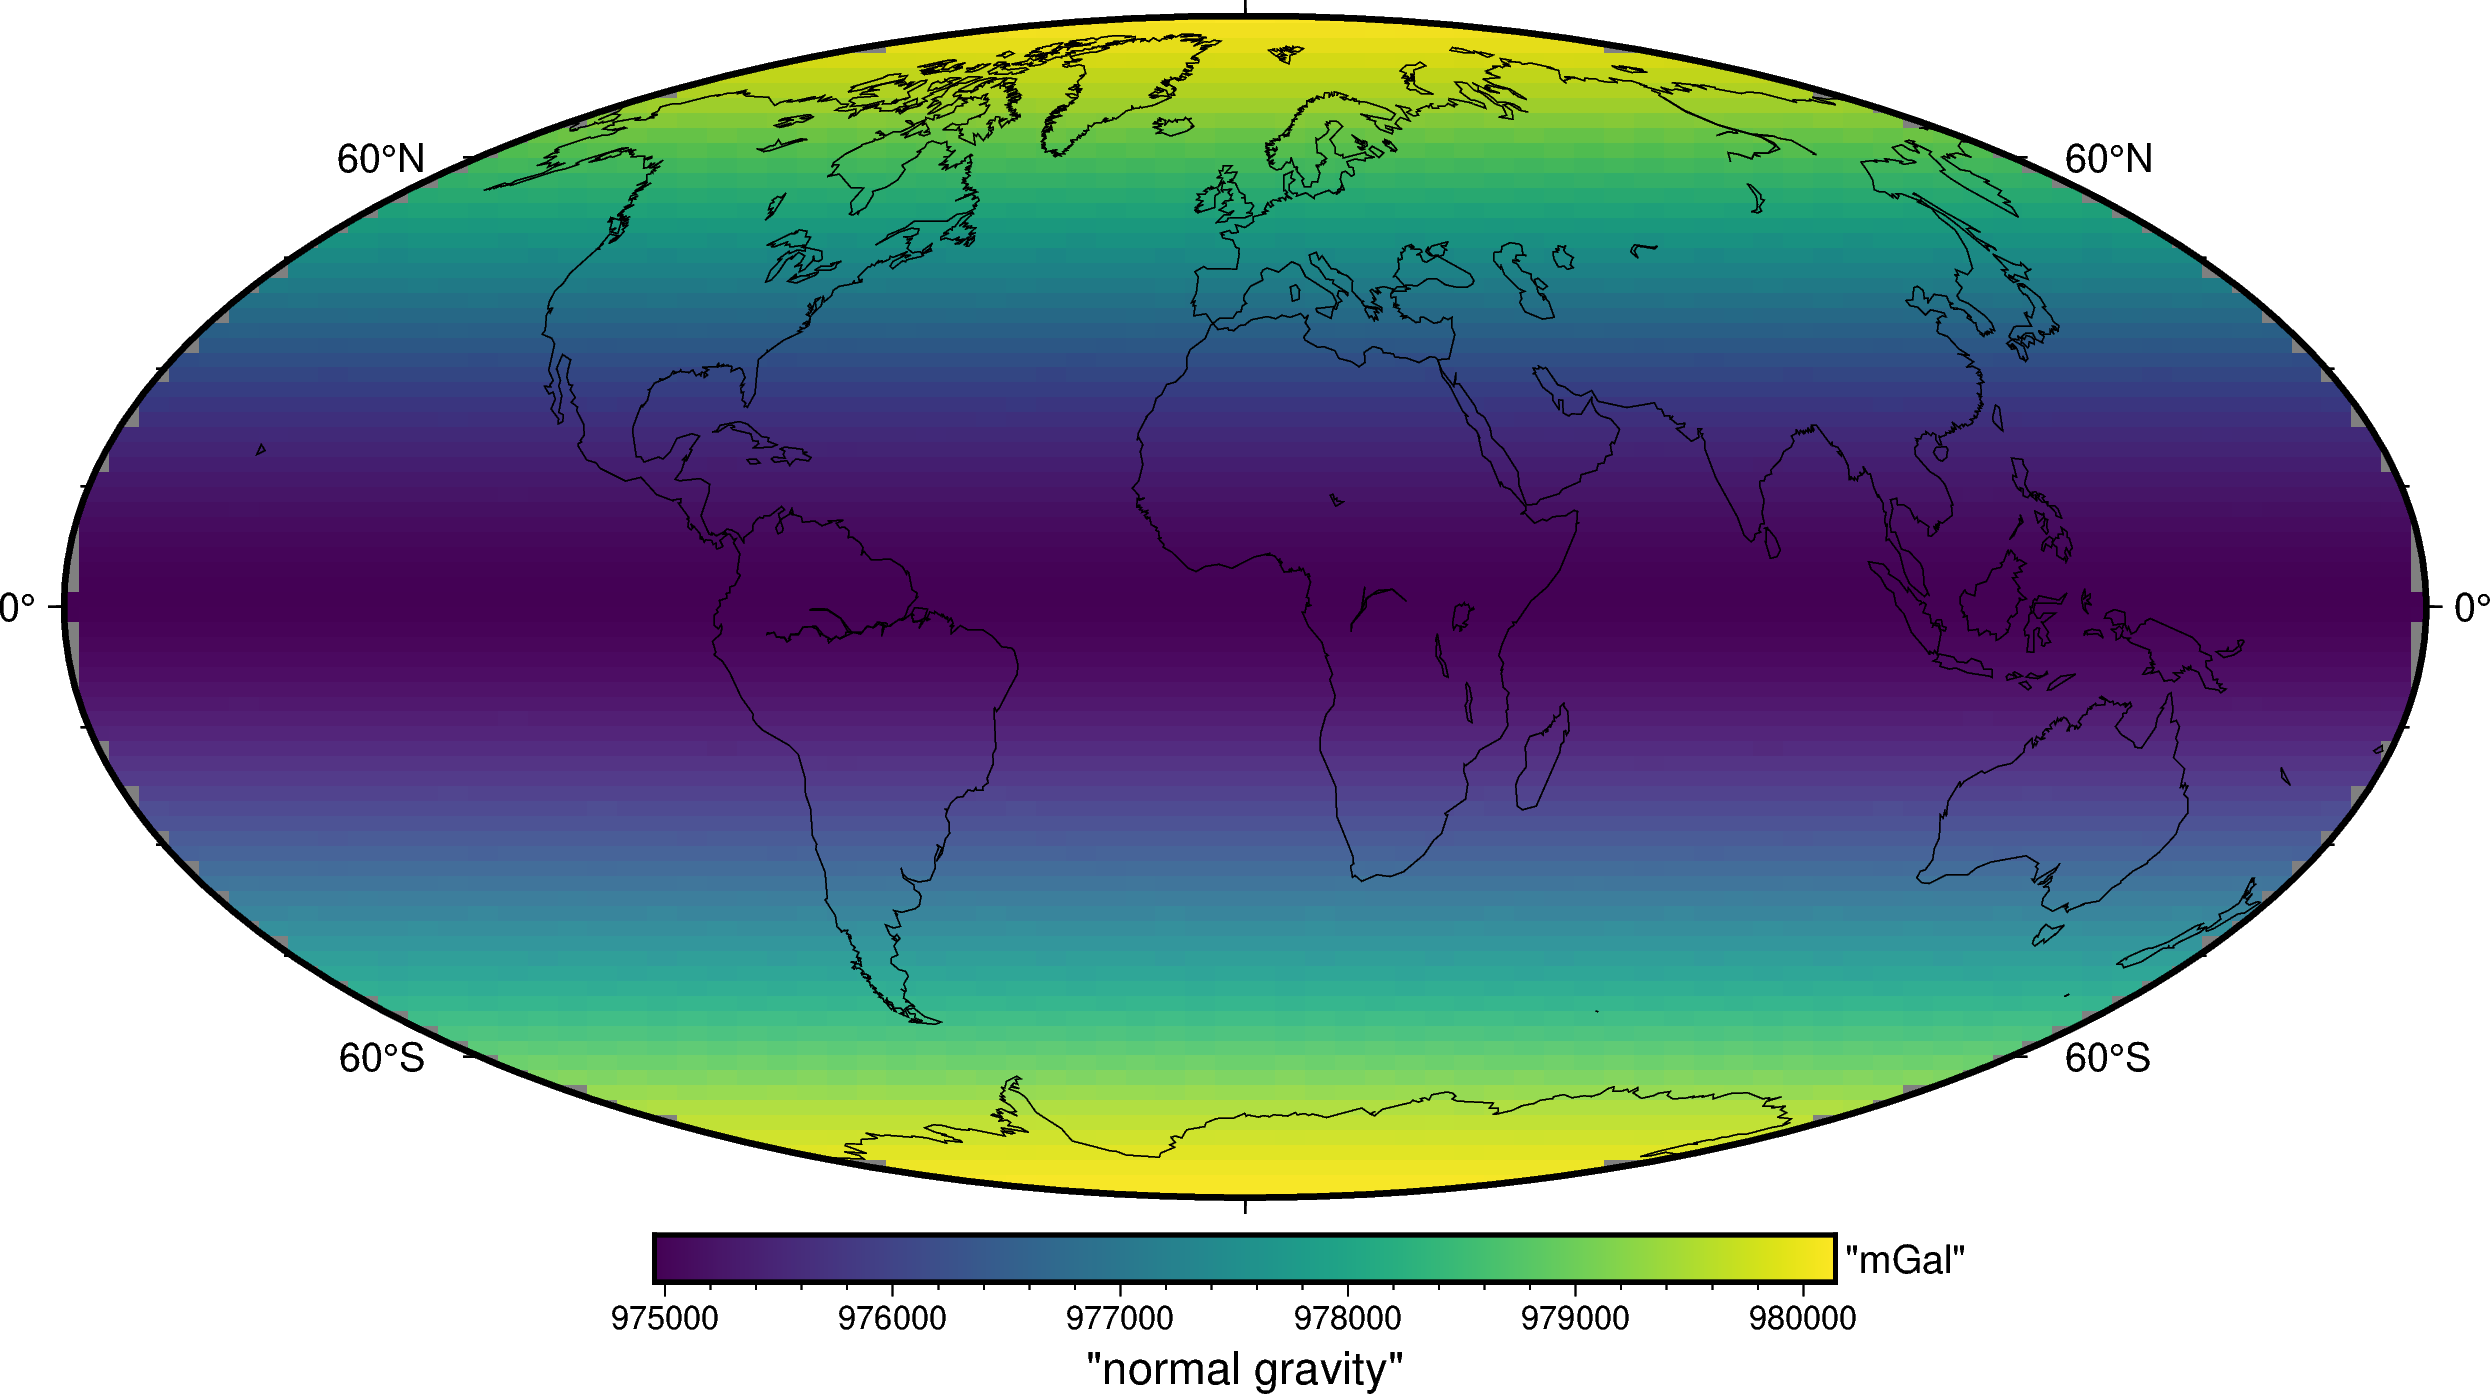

In [27]:
fig = pygmt.Figure()
fig.grdimage(
    normal_gravity,
    projection="W20c",
    cmap="viridis",
    shading="+a45+nt0.2",
)
fig.basemap(frame=["af", "WEsn"])
fig.colorbar(
    position="JCB+w10c",
    frame=["af", 'y+l"mGal"', 'x+l"normal gravity"'],
)
fig.coast(shorelines=True, resolution="c", area_thresh=1e4)
fig.show()

In [28]:
gravity_disturbance = gravity - normal_gravity
print(gravity_disturbance)


<xarray.DataArray (latitude: 80, longitude: 80)> Size: 51kB
array([[-138034.01455991, -138040.91681392, -138046.33125926, ...,
        -138015.43882102, -138025.25399626, -138033.67774984],
       [-134488.06973482, -134554.08907849, -134540.54773981, ...,
        -134098.76715784, -134331.72655889, -134483.29847733],
       [-113750.74005255, -112665.17171732, -110891.23337716, ...,
        -112971.20244975, -113771.52269627, -113774.92091986],
       ...,
       [ -11653.0080619 ,  -13116.60787277,  -14126.79593026, ...,
          -7191.46663096,   -9582.62216539,  -11576.86735632],
       [  -9066.46551743,   -9682.01031997,  -10130.13259591, ...,
          -7316.4133745 ,   -8252.35637634,   -9035.68001935],
       [   2834.31505041,    2812.93241938,    2796.33334196, ...,
           2892.27041684,    2861.58148442,    2835.36143156]])
Coordinates:
  * latitude   (latitude) float64 640B -89.9 -87.62 -85.35 ... 85.35 87.62 89.9
  * longitude  (longitude) float64 640B -179.9 -175.3 

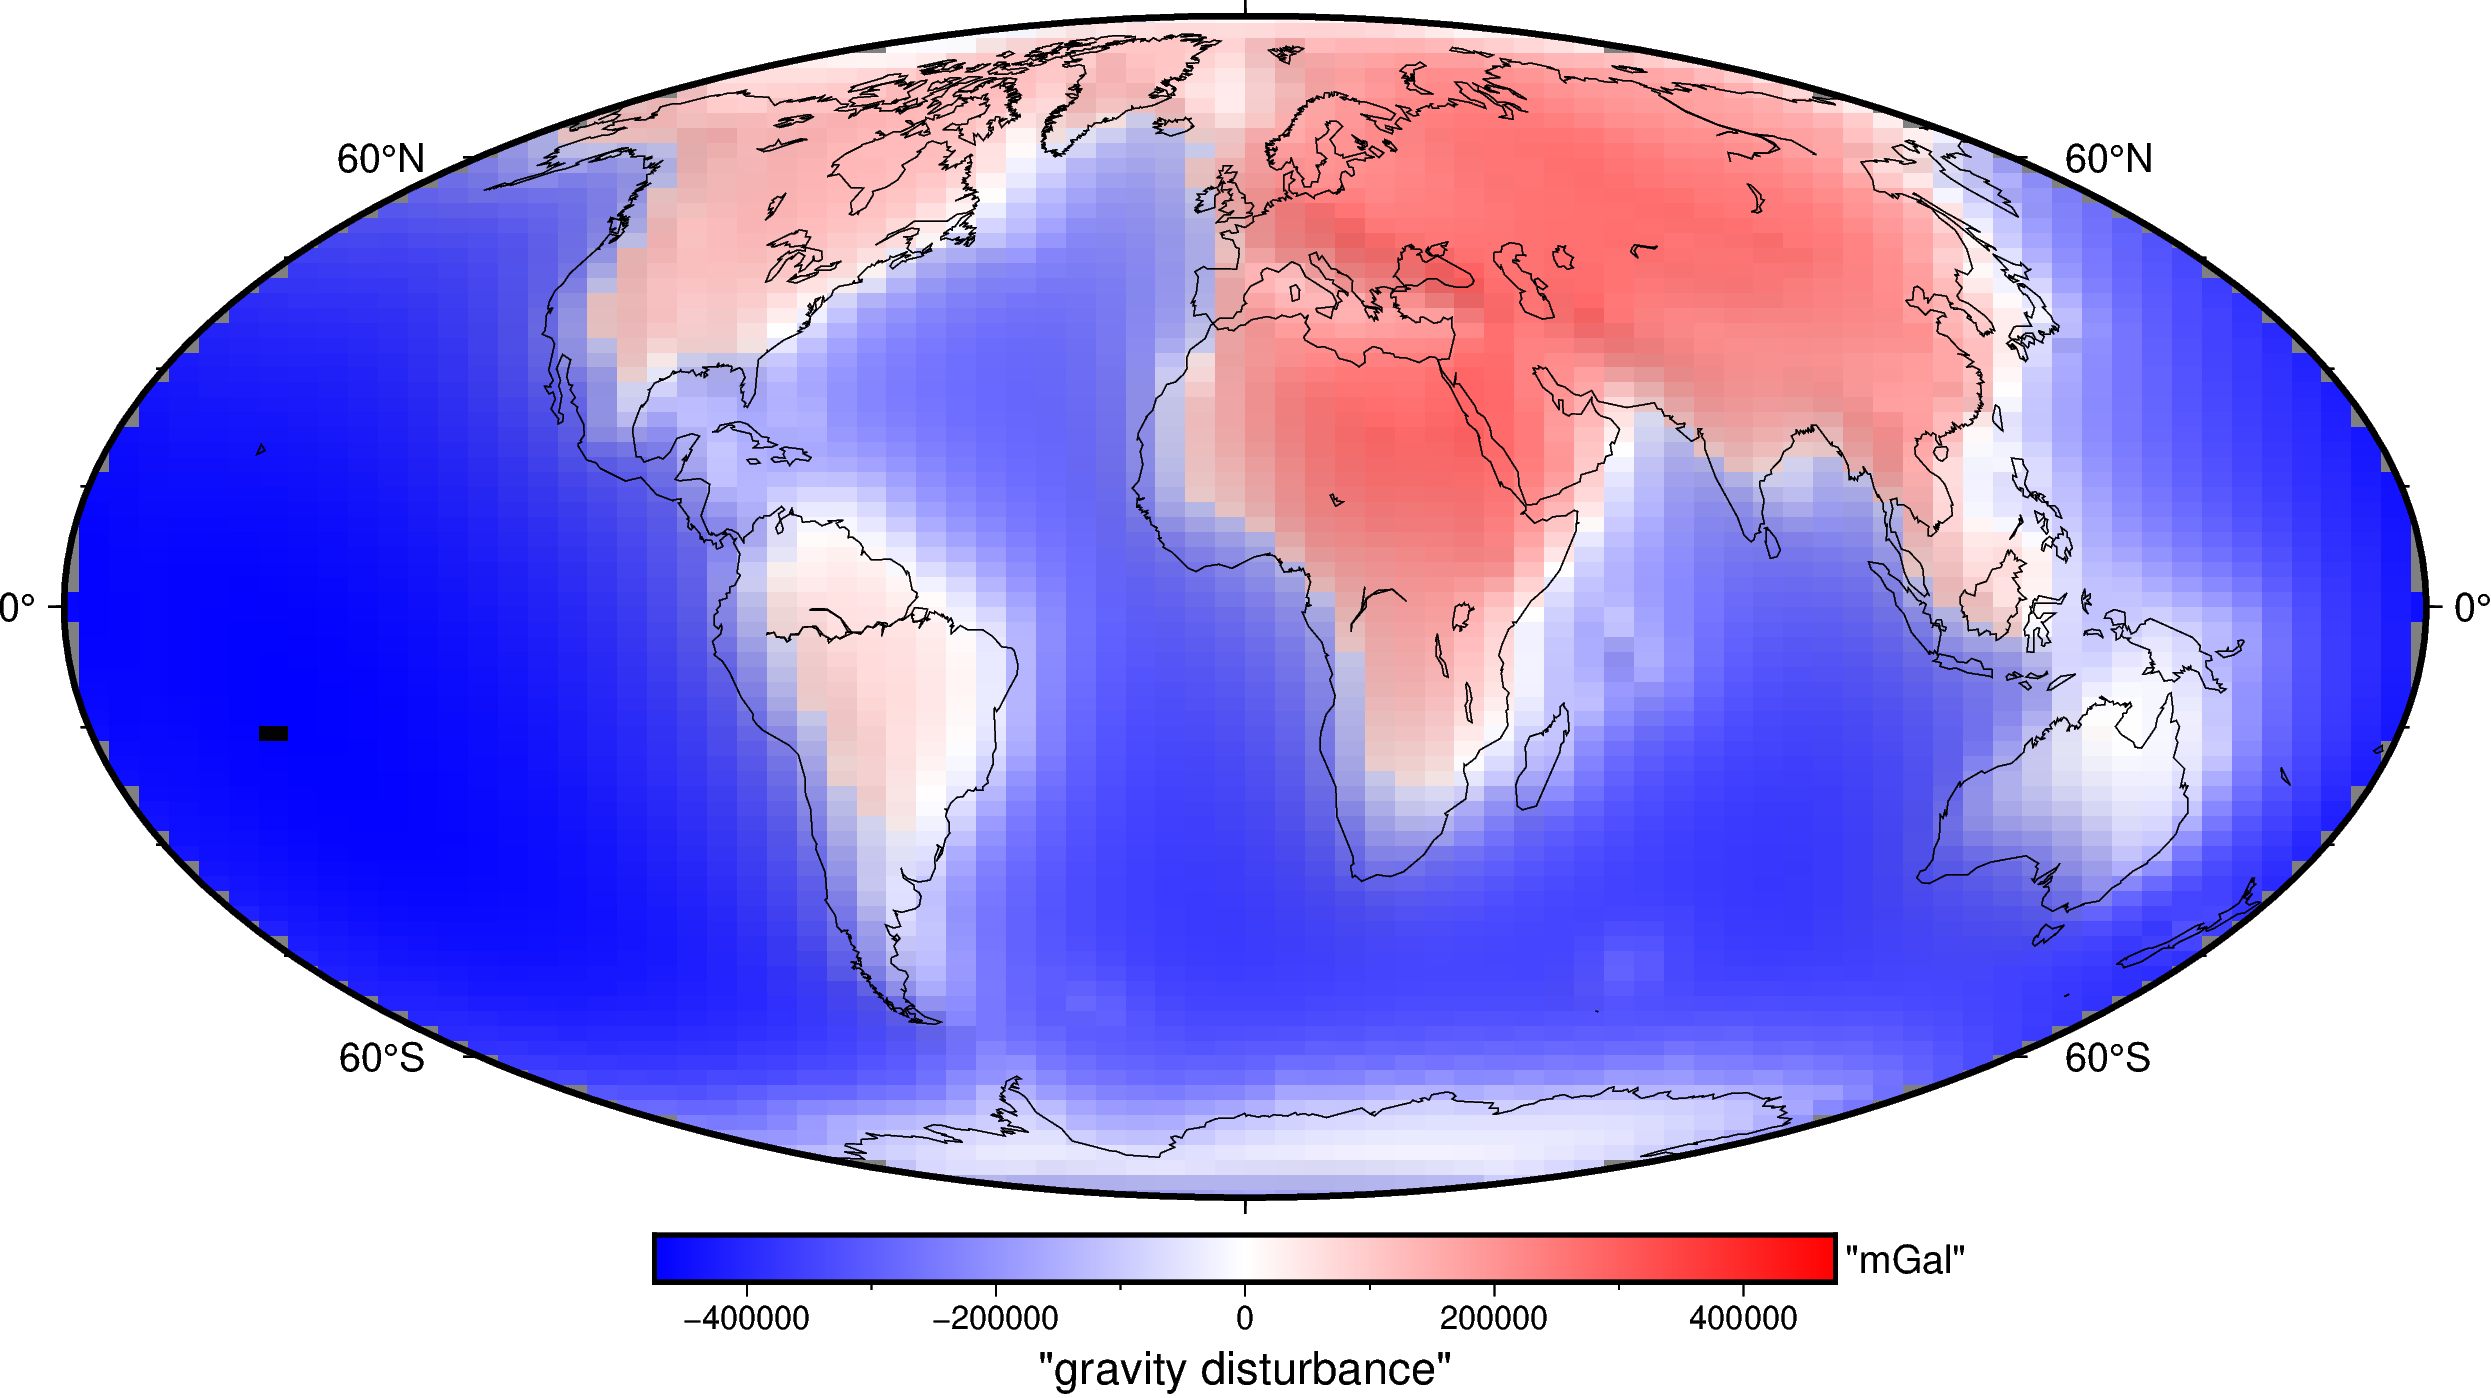

In [29]:
maxabs = vd.maxabs(gravity_disturbance)

fig = pygmt.Figure()
pygmt.makecpt(series=[-maxabs, maxabs], cmap="polar+h")
fig.grdimage(
    gravity_disturbance,
    projection="W20c",
    cmap=True,
    shading="+a45+nt0.2",
)
fig.basemap(frame=["af", "WEsn"])
fig.colorbar(
    position="JCB+w10c",
    frame=["af", 'y+l"mGal"', 'x+l"gravity disturbance"'],
)
fig.coast(shorelines=True, resolution="c", area_thresh=1e4)
fig.show()